In [ ]:
import os
from IPython.display import Image, display
from dotenv import load_dotenv
import warnings
warnings.filterwarnings("ignore")

load_dotenv()

True

# Setting up our LLM (gpt-4.1-nano)

In [ ]:
from langchain_openai import ChatOpenAI 

llm = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

# Our Question

In [ ]:
question = "What is the core break-through in deep-seek v3?"

# Answering without RAG

In [73]:
print(llm.invoke(question).content)

As of my knowledge cutoff in October 2023, there is no publicly available information about a product or technology called "Deep-Seek v3." It’s possible that it is a proprietary or emerging technology not widely documented yet, or perhaps a typo or miscommunication.

If you can provide more context or clarify the name or field related to "Deep-Seek v3," I’d be happy to help further!


# Load Documents

In [ ]:
from langchain.document_loaders import PyPDFLoader

pdf_directory = "Data" 

documents = []
for filename in os.listdir(pdf_directory):
    print(f"Processing file {filename}")
    if filename.endswith(".pdf"):
        loader = PyPDFLoader(os.path.join(pdf_directory, filename))
        documents.extend(loader.load())

Processing file llama-3.pdf
Processing file deepseek-v3.pdf


# Having a look at documents

In [74]:
documents

[Document(metadata={'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'creationdate': '2024-11-26T01:40:49+00:00', 'author': '', 'keywords': '', 'moddate': '2024-11-26T01:40:49+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'subject': '', 'title': '', 'trapped': '/False', 'source': 'Data/llama-3.pdf', 'total_pages': 92, 'page': 0, 'page_label': '1'}, page_content='The Llama 3 Herd of Models\nLlama Team, AI @ Meta 1\n1A detailed contributor list can be found in the appendix of this paper.\nModern artificial intelligence (AI) systems are powered by foundation models. This paper presents a\nnew set of foundation models, called Llama 3. It is a herd of language models that natively support\nmultilinguality, coding, reasoning, and tool usage. Our largest model is a dense Transformer with\n405B parameters and a context window of up to 128K tokens. This paper presents an extensive\nempirical evaluation of Llam

In [4]:
print(f"Total document Pages: {len(documents)}  pages")

Total document Pages: 145  pages


# Chunking: Recursive Character Text Splitter

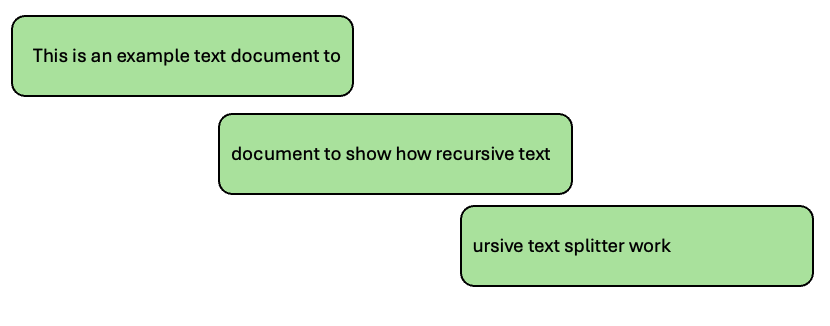

In [88]:
display(Image(filename='rts.png'))

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter  

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=200)
texts = text_splitter.split_documents(documents) 
len(texts)

448

# Build Vector Store

In [ ]:
from langchain_chroma import Chroma
from langchain.embeddings import OpenAIEmbeddings 

persist_directory = "chroma_db"

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

Chroma.from_documents(texts, embeddings, persist_directory=persist_directory)

print("ChromaDB built successfully.")

ChromaDB built successfully.


# Use the vectorstore to create a retriever

In [17]:
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embeddings)
retriever = vectordb.as_retriever()

# Augmentation Phase: Create a QA chain

How RetrievalQA works?
inputs: 
- llm: The language model to use for generating answers.
- retriever: The retriever to use for retrieving relevant documents. (From the vector store)

How it internally works?
- It first retrieves relevant documents using the retriever.
- Aguments the retrieved documents with the question. 
- Passes the augmented question to the LLM to generate an answer.

In [ ]:
from langchain.chains import RetrievalQA

qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=retriever,return_source_documents=True)
print(qa.combine_documents_chain.llm_chain.prompt.messages[0].prompt.template)
print(qa.combine_documents_chain.llm_chain.prompt.messages[1].prompt.template)

Use the following pieces of context to answer the user's question. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.
----------------
{context}
{question}


# RAG

In [54]:
print(qa.invoke(question)["result"])

The core breakthrough in DeepSeek-V3 is its demonstrated strong capability in handling extremely long-context tasks, validated by its top performance on LongBench v2. This long-context ability is further supported by its architecture, which includes innovations like Multi-head Latent Attention (MLA) for efficient inference and DeepSeekMoE, enabling it to process and understand lengthy inputs effectively.


# Also outputs the source documents with meta-data

In [55]:
qa.invoke(question)

{'query': 'What is the core break-through in deep-seek v3?',
 'result': "The core breakthrough in DeepSeek-V3 is its demonstrated strong capability in handling extremely long-context tasks, validated by its top performance on LongBench v2. This long-context ability is further supported by its architecture, which includes innovations like Multi-head Latent Attention (MLA) for efficient inference and DeepSeekMoE. Additionally, DeepSeek-V3's advanced knowledge distillation techniques significantly enhance its code generation, mathematical reasoning, and problem-solving capabilities, especially in complex benchmarks. These innovations collectively contribute to its state-of-the-art performance across various domains, including long-context understanding, coding, math, and Chinese factual knowledge.",
 'source_documents': [Document(id='ec5249a4-4ce8-4dd4-9aad-9f7e10c33361', metadata={'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5',

# Show how it works internally

# Retrive the top 5 documents

In [ ]:
retrived_documents = vectordb.similarity_search(query=question,k=5)

[Document(id='ec5249a4-4ce8-4dd4-9aad-9f7e10c33361', metadata={'page_label': '32', 'creationdate': '2025-02-19T02:11:22+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'title': '', 'moddate': '2025-02-19T02:11:22+00:00', 'creator': 'LaTeX with hyperref', 'source': 'Data/deepseek-v3.pdf', 'keywords': '', 'subject': '', 'author': '', 'total_pages': 53, 'trapped': '/False', 'producer': 'pdfTeX-1.40.25', 'page': 31}, page_content='demonstrates the strong capability of DeepSeek-V3 in handling extremely long-context tasks.\nThe long-context capability of DeepSeek-V3 is further validated by its best-in-class performance\non LongBench v2, a dataset that was released just a few weeks before the launch of DeepSeek\nV3. On the factual knowledge benchmark, SimpleQA, DeepSeek-V3 falls behind GPT-4o and\nClaude-Sonnet, primarily due to its design focus and resource allocation. DeepSeek-V3 assigns\nmore training tokens to learn Chin

# Create a Prompt by Agumenting the retrieved documents

In [67]:
context = "Context:\n\n" + "\n\n".join([doc.page_content for doc in retrived_documents])
qa_prompt = f"""
Use the following pieces of context to answer the user's question. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.
----------------
{context} 

Question: {question}
"""
print(qa_prompt)


Use the following pieces of context to answer the user's question. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.
----------------
Context:

demonstrates the strong capability of DeepSeek-V3 in handling extremely long-context tasks.
The long-context capability of DeepSeek-V3 is further validated by its best-in-class performance
on LongBench v2, a dataset that was released just a few weeks before the launch of DeepSeek
V3. On the factual knowledge benchmark, SimpleQA, DeepSeek-V3 falls behind GPT-4o and
Claude-Sonnet, primarily due to its design focus and resource allocation. DeepSeek-V3 assigns
more training tokens to learn Chinese knowledge, leading to exceptional performance on the
C-SimpleQA. On the instruction-following benchmark, DeepSeek-V3 significantly outperforms
its predecessor, DeepSeek-V2-series, highlighting its improved ability to understand and adhere
to user-defined format constraints.
Code and Math Benchmarks. Coding is a 

# Generation Step

In [68]:
print(llm.invoke(qa_prompt).content)

The core breakthrough in DeepSeek-V3 is its strong capability to handle extremely long-context tasks, demonstrated by its best-in-class performance on LongBench v2 and its ability to process and reason over very lengthy inputs effectively. This long-context handling is further validated by its superior performance on various benchmarks, including long-context and reasoning tasks, highlighting its advanced architecture and training techniques designed to extend context length and improve reasoning over extended sequences.
